In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import requests
import json
import time
from mysql_utils import PyMySQL
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

E:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import pandas as pd
df = pd.read_csv('ppr-20211342.csv') # Read in all the rows, but skips the first one as it is a header.

# 1. Prepare a data quality report for your CSV file. Below you have a set of guideline steps to help you in this process.

## 1. Check how many rows and columns your CSV has.

In [3]:
total_rows=len(df.axes[0]) # Axes of 0 is for a row
total_cols=len(df.axes[1]) # Axes of 1 is for a column

In [4]:
print("number of rows and columns:", df.shape)

number of rows and columns: (10000, 9)


## 2. Print the first and the last 5 rows.

In [5]:
df.head() # Read the first 5 rows and the default is 5 rows

,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,03/03/2017,"86 MULLAGHMATT, MONAGHAN",NaN,Monaghan,"€65,000.00",Yes,No,Second-Hand Dwelling house /Apartment,NaN
1,12/03/2020,"13 FABER GROVE, DUN LAOGHAIRE, DUBLIN",NaN,Dublin,"€320,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
2,09/07/2010,"32 Allenton Drive, Tallaght",Dublin 24,Dublin,"€194,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
3,29/10/2019,"15 An Fuaran, Dublin Road, Oranmore",NaN,Galway,"€345,010.00",No,Yes,New Dwelling house /Apartment,NaN
4,11/07/2019,"CHERRYORCHARD, ENNISCORTHY, WEXFORD",NaN,Wexford,"€172,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


In [6]:
df.tail() # Read the last 5 rows and the default is 5 rows

,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
9995,16/06/2016,"13 CHERBURY GARDENS, BOOTERSTOWN AVE, BLACKROCK",NaN,Dublin,"€850,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
9996,09/11/2020,"204 ALYMER PARK, NAAS, CO KILDARE",NaN,Kildare,"€276,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
9997,15/08/2014,"27 Griffinrath Manor, Maynooth",NaN,Kildare,"€427,312.77",No,Yes,New Dwelling house /Apartment,greater than 125 sq metres
9998,14/08/2021,"3 BEECH WOOD, CLONBALT WOODS, LONGFORD",NaN,Longford,"€197,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
9999,13/07/2016,"16 Ash Grove, Ellis Wood, Killarney Road",NaN,Limerick,"€62,609.00",No,Yes,New Dwelling house /Apartment,greater than 125 sq metres


## 3. Convert the features to their appropriate data types (e.g., decide which features are more appropriate as  continuous and which ones as categorical types).

In [7]:
df.dtypes # Show the feature type

Date of Sale (dd/mm/yyyy)    object
Address                      object
Postal Code                  object
County                       object
Price (€)                    object
Not Full Market Price        object
VAT Exclusive                object
Description of Property      object
Property Size Description    object
dtype: object

In [8]:
# Remove space in or around feature names
df.columns = df.columns.str.replace(' ', '')

# Check the space have been removed
df.columns

Index(['DateofSale(dd/mm/yyyy)', 'Address', 'PostalCode', 'County', 'Price(€)',
       'NotFullMarketPrice', 'VATExclusive', 'DescriptionofProperty',
       'PropertySizeDescription'],
      dtype='object')

In [9]:
# Convert data feature to data type(datatime64[ns])
df['DateofSale(dd/mm/yyyy)'] = df['DateofSale(dd/mm/yyyy)'].astype('datetime64[ns]')

In [10]:
# Remove Euro sign
df['Price(€)'] = df['Price(€)'].map(lambda x: x.lstrip('€'))

In [11]:
# Remove comma sign
df['Price(€)'] = df['Price(€)'].str.replace(',', '')

In [12]:
# Convert data feature to data type(float64)
df['Price(€)'] = df['Price(€)'].astype('float64')

In [13]:
# Select columns containing categorical data
categorical_columns = ['PostalCode','County','NotFullMarketPrice','VATExclusive','DescriptionofProperty','PropertySizeDescription']

# Convert data type to category for these columns
for column in categorical_columns:
    df[column] = df[column].astype('category')

In [14]:
df['Address'] = df['Address'].astype('object')

In [15]:
# Check if the conversion is complete
df.dtypes

DateofSale(dd/mm/yyyy)     datetime64[ns]
Address                            object
PostalCode                       category
County                           category
Price(€)                          float64
NotFullMarketPrice               category
VATExclusive                     category
DescriptionofProperty            category
PropertySizeDescription          category
dtype: object

## 4. Look for duplicate rows and columns. Consider whether it makes sense to keep them or drop them.

### Rows

In [16]:
# Print the number of duplicates without the original rows that were replicated.
print('Number of duplicate (excluding first) rows in the table is: ', df.duplicated().sum())

# Check for duplicate rows. 
# To designate all duplicates as true, including the original rows that were replicated, use "keep=False."
print('Number of duplicate rows (including first) in the table is:', df[df.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) rows in the table is:  0
Number of duplicate rows (including first) in the table is: 0


### Columns

In [17]:
# Check for duplicate columns
# Transpose the df so that the columns become rows, then perform the same check as before.

dfT = df.T
print("Number of duplicate (excluding first) columns in the table is: ", dfT.duplicated().sum())
print("Number of duplicate (including first) columns in the table is: ",  dfT[dfT.duplicated(keep=False)].shape[0])

# Duplicate returns a Boolean value, therefore if the column is duplicated, True will be returned.
print('\n')
print('If the column is duplicated, True will be returned.')
print(dfT.duplicated())

Number of duplicate (excluding first) columns in the table is:  0
Number of duplicate (including first) columns in the table is:  0


If the column is duplicated, True will be returned.
DateofSale(dd/mm/yyyy)     False
Address                    False
PostalCode                 False
County                     False
Price(€)                   False
NotFullMarketPrice         False
VATExclusive               False
DescriptionofProperty      False
PropertySizeDescription    False
dtype: bool


In [18]:
# Show duplicate row data that can be dropped
df[df.duplicated(keep=False)]

# There are no duplicate rows of data in this CSV

,DateofSale(dd/mm/yyyy),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription


In [19]:
# Nothing changed
df.shape

(10000, 9)

## 5. Look for constant columns. Consider whether it makes sense to keep them or drop them.

In [20]:
# Print table with categorical statistics
df.select_dtypes(['category']).describe().T

,count,unique,top,freq
PostalCode,1918,22,Dublin 15,247
County,10000,26,Dublin,3275
NotFullMarketPrice,10000,2,No,9480
VATExclusive,10000,2,No,8440
DescriptionofProperty,10000,2,Second-Hand Dwelling house /Apartment,8400
PropertySizeDescription,1022,4,greater than or equal to 38 sq metres and less...,719


All categorical data's unique values is greater than 1

- PostalCode has 22 unique values
- County has 26 unique values
- NotFullMarketPrice has 2 unique values
- VATExclusive has 2 unique values
- DescriptionofProperty has 2 unique values
- PropertySizeDescription has 4 unique values

In [21]:
# Print table with objective statistic
df.select_dtypes(['object']).describe().T

,count,unique,top,freq
Address,10000,9990,"BALLYTEAGUE, KILMEAGUE, NAAS",2


- Address has 9990 unique values

In [22]:
# Print table with continuous statistic
df.select_dtypes(['float64']).describe().T

,count,mean,std,min,25%,50%,75%,max
Price(€),10000.0,267581.872415,780575.142298,5252.0,120000.0,200000.0,308370.04,60000000.0


#### All data standard deviations are non-zero. Thus, all rows do not contain a single constant value and in this case, none of the continuous features are constant.
#### Result : There are no constant columns.

## 6. Check the logical integrity of your data. 

In [23]:
# Create a new dataframe
test_1 = df[['DescriptionofProperty','VATExclusive']]

In [24]:
# Check if the new dataframe have created
test_1.head()

,DescriptionofProperty,VATExclusive
0,Second-Hand Dwelling house /Apartment,No
1,Second-Hand Dwelling house /Apartment,No
2,Second-Hand Dwelling house /Apartment,No
3,New Dwelling house /Apartment,Yes
4,Second-Hand Dwelling house /Apartment,No


In [25]:
# Replace DescriptionofProperty's strings to No or Yes
test_1 = test_1.replace({'DescriptionofProperty':
    {'Second-Hand Dwelling house /Apartment':'No',
    'New Dwelling house /Apartment':'Yes'
}})

In [26]:
# Check if the strings replace successful
test_1.head()

,DescriptionofProperty,VATExclusive
0,No,No
1,No,No
2,No,No
3,Yes,Yes
4,No,No


In [27]:
# Test_1 check if VATExclusive is not equal to DescriptionofProperty and show all differences
test_1 = test_1[['DescriptionofProperty','VATExclusive']][test_1['VATExclusive'] != test_1['DescriptionofProperty']]
print("Number of rows failing the test: ", test_1.shape[0])
test_1.head(40)

Number of rows failing the test:  40


,DescriptionofProperty,VATExclusive
44,Yes,No
830,Yes,No
911,Yes,No
918,Yes,No
1180,Yes,No
1373,Yes,No
1459,Yes,No
1738,Yes,No
1850,Yes,No
1865,Yes,No


In [28]:
# Test_2 check for null values
df.isnull().sum()

DateofSale(dd/mm/yyyy)        0
Address                       0
PostalCode                 8082
County                        0
Price(€)                      0
NotFullMarketPrice            0
VATExclusive                  0
DescriptionofProperty         0
PropertySizeDescription    8978
dtype: int64

### As we can see here the postalcode has many null values, so we can check the logical integrity

In [29]:
df['PostalCode'].notnull()

0       False
1       False
2        True
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: PostalCode, Length: 10000, dtype: bool

In [30]:
df[df['PostalCode'].notnull()]

,DateofSale(dd/mm/yyyy),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription
2,2010-09-07,"32 Allenton Drive, Tallaght",Dublin 24,Dublin,194000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
6,2019-04-30,"25 GRAND CANAL WHARF, SOUTH DOCK RD, RINGSEND ...",Dublin 4,Dublin,425000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
7,2019-12-23,"66 THE MALTHOUSE, MARROWBONE LANE, DUBLIN 8",Dublin 8,Dublin,204000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
13,2017-07-27,"13 RICHMOND HALL, MOUNT ST ANNES, MILLTOWN DUB...",Dublin 6,Dublin,301762.11,No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
21,2016-12-20,"12 CABRA PARK, PHIBSBOROUGH, DUBLIN 7",Dublin 7,Dublin,402000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
...,...,...,...,...,...,...,...,...,...
9981,2020-11-20,"APT 112, 109 PARNELL ST, DUBLIN 1",Dublin 1,Dublin,208000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
9982,2017-12-22,"30 THE WATERFRONT, HANOVER QUAY, DUBLIN 2",Dublin 2,Dublin,540000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
9984,2016-12-09,"11 BOLBROOK DRIVE, TALLAGHT, DUBLIN 24",Dublin 24,Dublin,220000.00,No,No,Second-Hand Dwelling house /Apartment,NaN
9991,2018-09-21,"BALLINATRAY HOUSE, KILLADREENAN, NEWCASTLE",Dublin 5,Wicklow,850000.00,No,No,Second-Hand Dwelling house /Apartment,NaN


### As we can see here, some addresses include dublin, but some do not, so I want to find the addresses which include DUBLIN

In [31]:
# Case I'm not sure there are all upperletter, so I translate them to upperletter first
df["Address_1"] = df["Address"].apply(lambda x: x.upper()) 

# Check if Address contains string "DUBLIN"
df[df["Address"].str.contains("DUBLIN")==True]

,DateofSale(dd/mm/yyyy),Address,PostalCode,County,Price(€),NotFullMarketPrice,VATExclusive,DescriptionofProperty,PropertySizeDescription,Address_1
1,2020-12-03,"13 FABER GROVE, DUN LAOGHAIRE, DUBLIN",NaN,Dublin,320000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,"13 FABER GROVE, DUN LAOGHAIRE, DUBLIN"
6,2019-04-30,"25 GRAND CANAL WHARF, SOUTH DOCK RD, RINGSEND ...",Dublin 4,Dublin,425000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,"25 GRAND CANAL WHARF, SOUTH DOCK RD, RINGSEND ..."
7,2019-12-23,"66 THE MALTHOUSE, MARROWBONE LANE, DUBLIN 8",Dublin 8,Dublin,204000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,"66 THE MALTHOUSE, MARROWBONE LANE, DUBLIN 8"
13,2017-07-27,"13 RICHMOND HALL, MOUNT ST ANNES, MILLTOWN DUB...",Dublin 6,Dublin,301762.11,No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,"13 RICHMOND HALL, MOUNT ST ANNES, MILLTOWN DUB..."
21,2016-12-20,"12 CABRA PARK, PHIBSBOROUGH, DUBLIN 7",Dublin 7,Dublin,402000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,"12 CABRA PARK, PHIBSBOROUGH, DUBLIN 7"
...,...,...,...,...,...,...,...,...,...,...
9966,2016-01-14,"5 LIBERTY COURT, LR CLANBRASSIL ST, DUBLIN 8",Dublin 8,Dublin,180000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,"5 LIBERTY COURT, LR CLANBRASSIL ST, DUBLIN 8"
9981,2020-11-20,"APT 112, 109 PARNELL ST, DUBLIN 1",Dublin 1,Dublin,208000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,"APT 112, 109 PARNELL ST, DUBLIN 1"
9982,2017-12-22,"30 THE WATERFRONT, HANOVER QUAY, DUBLIN 2",Dublin 2,Dublin,540000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,"30 THE WATERFRONT, HANOVER QUAY, DUBLIN 2"
9984,2016-12-09,"11 BOLBROOK DRIVE, TALLAGHT, DUBLIN 24",Dublin 24,Dublin,220000.00,No,No,Second-Hand Dwelling house /Apartment,NaN,"11 BOLBROOK DRIVE, TALLAGHT, DUBLIN 24"


### There are 1751 houses or apartment are in Dublin

In [32]:
# Test_3
test_3 = df[["DateofSale(dd/mm/yyyy)"]]
# Create a DateCheck column and change values to no
test_3["DateCheck"] = "no"
# Set the condition, check if the date is between 2010-01-01 and 2022-03-07
test_3["DateCheck"] = np.where((test_3["DateofSale(dd/mm/yyyy)"] > '2010-01-01') & (test_3["DateofSale(dd/mm/yyyy)"] < '2022-03-07') , "True",test_3["DateCheck"])
# Return no if not in the range of date
test_3.loc[test_3["DateCheck"]=="no"]


,DateofSale(dd/mm/yyyy),DateCheck
1393,2022-10-01,no
2094,2022-06-01,no
3830,2022-07-01,no
4334,2022-07-01,no
6880,2022-05-01,no
6959,2022-05-01,no
7005,2022-06-01,no
7121,2022-06-01,no
8295,2022-04-01,no
8336,2022-11-01,no


### As we can see from test_3, there are 10 houses or apartments are over the date range.

## 7. Save your updated/cleaned data frame to a new csv file.

In [33]:
# Write the data frame to a new CSV file
df.to_csv('Residential_Property_Price_Prediction_20211342.csv', index=False)

## 8. Prepare a table with descriptive statistics for all the continuous features.

In [34]:
# Print table with descriptive statistic for the continuous feature
continuous_column = df.select_dtypes(['float64']).columns
df[continuous_column].describe().T

,count,mean,std,min,25%,50%,75%,max
Price(€),10000.0,267581.872415,780575.142298,5252.0,120000.0,200000.0,308370.04,60000000.0


## 9. Prepare a table with descriptive statistics for all the categorical features.

In [35]:
# Print table with descriptive statistics for the categorical features
categorical_columns = df.select_dtypes(['category']).columns
df[categorical_columns].describe().T

,count,unique,top,freq
PostalCode,1918,22,Dublin 15,247
County,10000,26,Dublin,3275
NotFullMarketPrice,10000,2,No,9480
VATExclusive,10000,2,No,8440
DescriptionofProperty,10000,2,Second-Hand Dwelling house /Apartment,8400
PropertySizeDescription,1022,4,greater than or equal to 38 sq metres and less...,719


In [36]:
# Print table with descriptive statistic for the objective feature
objective_column = df.select_dtypes(['object']).columns
df[objective_column].describe().T

,count,unique,top,freq
Address,10000,9990,"BALLYTEAGUE, KILMEAGUE, NAAS",2
Address_1,10000,9989,"16 LANDSDOWNE VILLAGE, KENMARE, KERRY",2


In [37]:
# Address_1 is for logical integrity

## 10. Plot histograms for all the continuous features

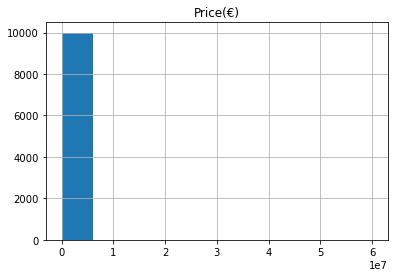

In [38]:
# Print histogram for continuous features
df[continuous_column].hist(layout=(6, 4), figsize=(30,30), bins=10)
plt.savefig('continuous_histogram.pdf')

## 11. Plot box plots for all the continuous features.

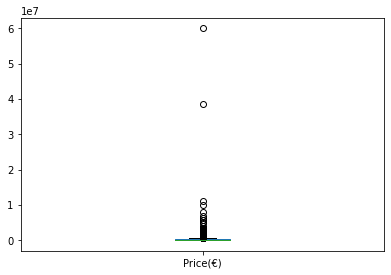

In [39]:
df[continuous_column].plot(kind='box', subplots=True, figsize=(30,30), layout=(6,4), sharex=False, sharey=False)
plt.savefig('continuous_boxplot.pdf')

## 12. Plot bar plots for all the categorical features.

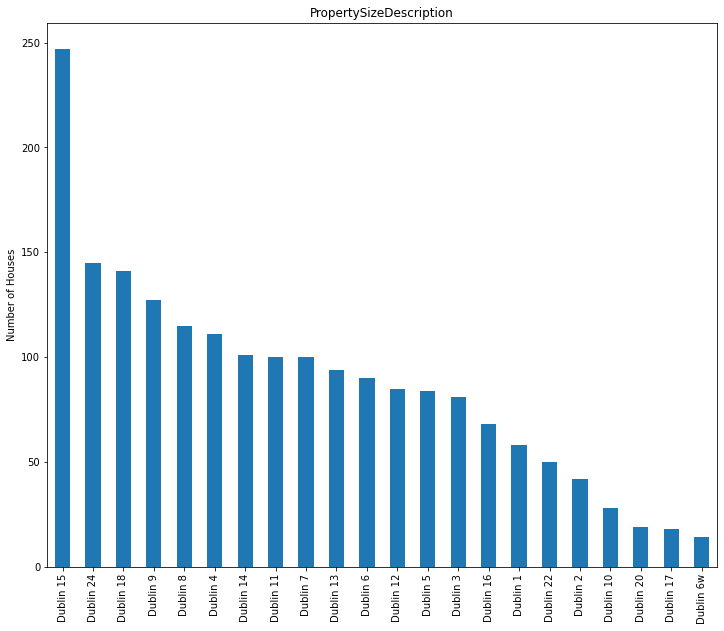

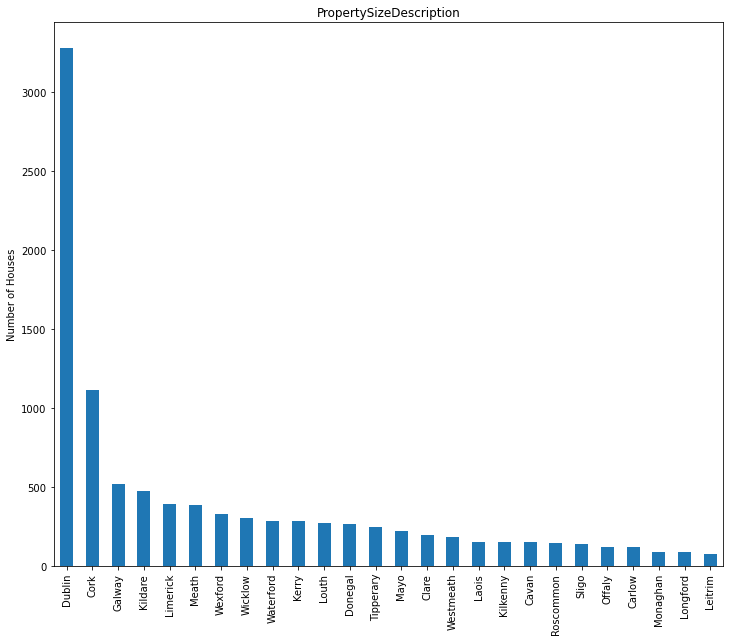

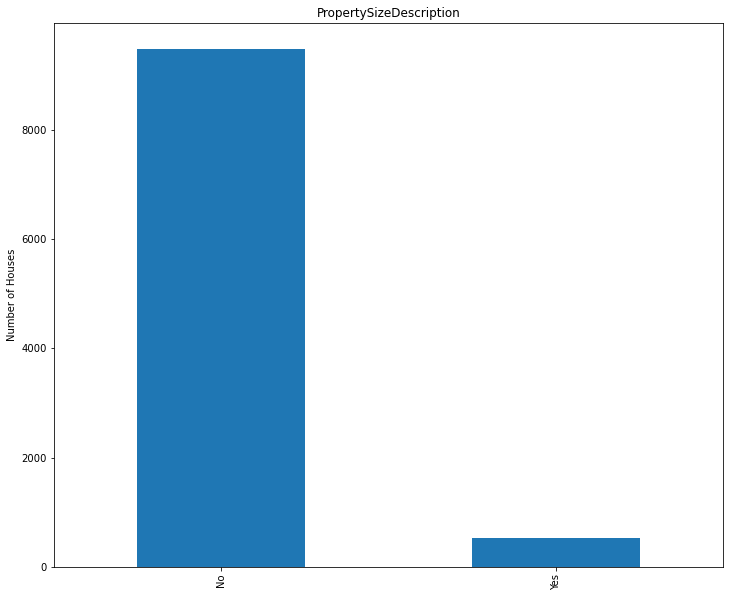

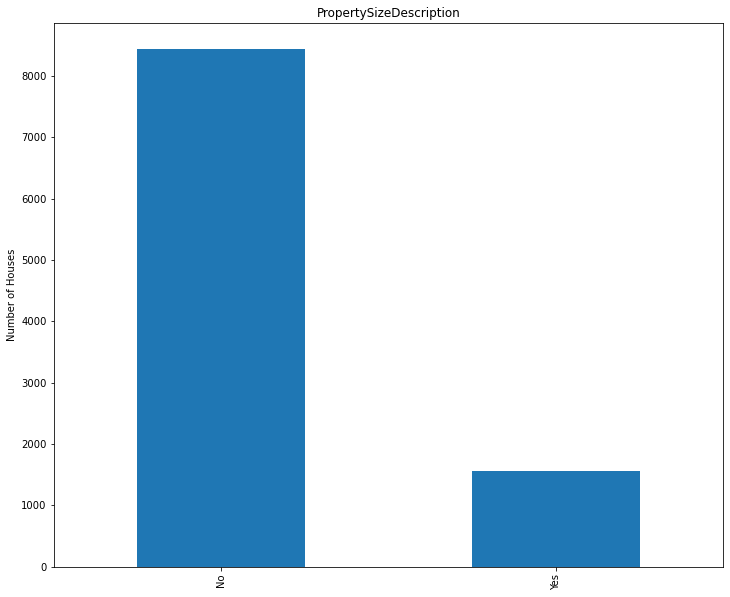

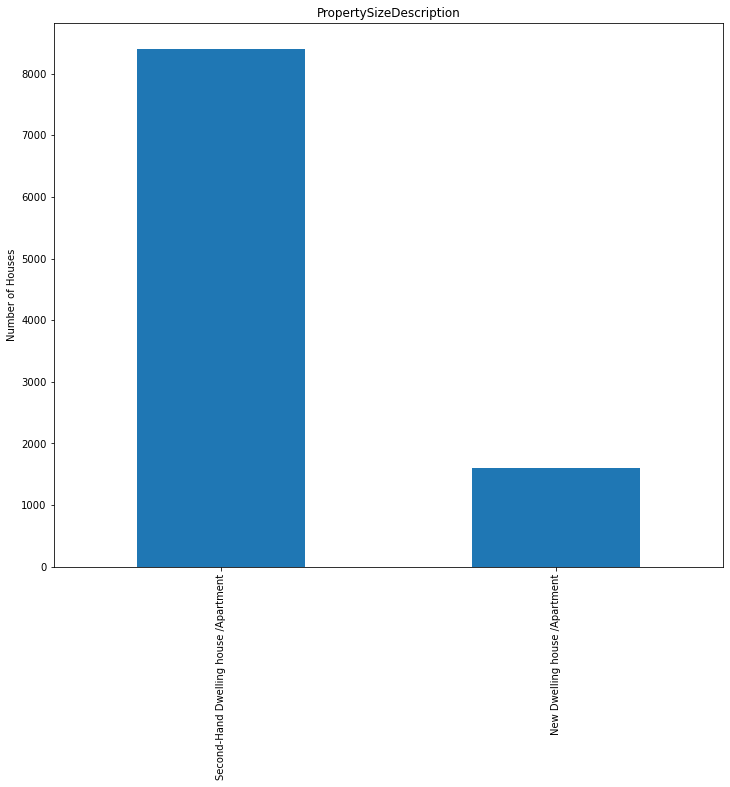

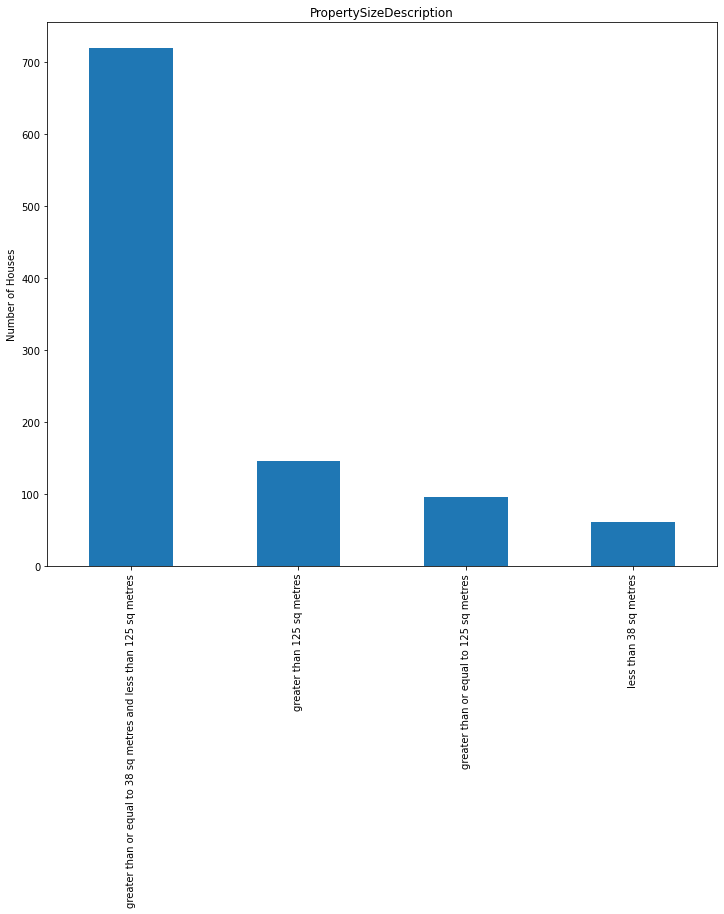

In [40]:
# Plot bar plots for all the catagorical features and save them in a single PDF file
with PdfPages('categorical_barplots.pdf') as pp:
    for col in categorical_columns:
        f = df[col].value_counts().plot(kind='bar', figsize=(12,10),title=column)
        plt.ylabel('Number of Houses')
        pp.savefig(f.get_figure())
        plt.show()

In [41]:
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_columns',None)
pd.set_option('display.width',1000)
pd.set_option('display.max_colwidth',1000)

# 2. Prepare a data quality plan for the cleaned CSV file.

### 2. Data Quality Plan
- 1. Date has exceeded the current time, may be a problem when the information is entered, but only within 10, accounting for a very low ratio, so you can do nothing;
- 2. Price has abnormal values: the price is found to be 6 times and 4 times the maximum value of the normal range, but considering that different assets can indeed have a large gap, for example, a large villa is much more expensive than a small house, so do nothing.
- 3. address format is not standard and there are duplicate data; there are 10 duplicate data; not unique, check Google API with address as parameter, some of them will appear multiple data, which means that some of the address itself cannot uniquely refer to a house, but this cannot be deleted, because it may be a problem when entering information, there is no way to investigate, so the original address The data can only do nothing, but can get the standard format address through Google API. Google API has a free credit of $200 per month, which can be transferred 40,000 times for free, which is more than enough for this data set of 10,000. This is more than enough for this data set of 10,000. If we use the crawler method, we need to spend a lot of effort to find the web page that can get all the detailed address of Ireland, and then write the crawler to get it, and that is probably worse than Google's data quality, so I choose to call Google API for this;
- 4. Postal Code and Property Size Description have too many missing values, accounting for up to 80 and 89.9 respectively.

### Summary of data quality plan:

| variable Names  |  Data Quality Issue  |  Handling Strategy  |
| ---- | ---- | ---- |
| DateofSale(dd/mm/yyyy) |  Outliers  |  Do Nothing  |
| Price(€) |  Outliers  |  Do Nothing  |
| Address |  Not standard  |  Use Google API  |
| Postal Code |  Too many NAN  |  Drop  |
| Property Size Description |  Too many NAN  |  Drop  |


In [51]:
df = pd.read_csv('ppr-20211342.csv') # Read in all the rows, but skips the first one as it is a header.

# Remove space in or around feature names
df.columns = df.columns.str.replace(' ', '')
# Convert data feature to data type(datatime64[ns])
df['DateofSale(dd/mm/yyyy)'] = df['DateofSale(dd/mm/yyyy)'].astype('datetime64[ns]')
df['Price(€)'] = df['Price(€)'].map(lambda x: x.lstrip('€'))
df['Price(€)'] = df['Price(€)'].str.replace(',', '')
df['Price(€)'] = df['Price(€)'].astype('float64')

# Select columns containing categorical data
categorical_columns = ['County','NotFullMarketPrice','VATExclusive','DescriptionofProperty', "PropertySizeDescription"]

# Convert data type to category for these columns
for column in categorical_columns:
    df[column] = df[column].astype('category')

df['Address'] = df['Address'].astype('object')

continuous_column = df.select_dtypes(['float64']).columns

In [52]:
df.rename(columns = {'DateofSale(dd/mm/yyyy)':'DateofSale'}, inplace = True)
df.rename(columns = {'Price(€)': "Price"}, inplace = True)

In [53]:
# Get more data from Google, and save to MySQL database, then we can get the datas on demand later, no need to get data from Google again
# And database is better than CSV file in one computer:
# Stored in the database, you can read and write anytime and anywhere, and you do not have to worry about data loss if you do a high-reliability solution. 
# If it is a csv file placed on a computer, it cannot be read and written anytime and anywhere, and if the computer is damaged, the data may be lost.
def get_address_from_google_to_db(row):
    time.sleep(0.2)
    address = "+".join(row.iloc[0].at["Address"].split(" "))
    response = requests.get(f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key=API_KEY')
    row["GoogleAddress"] = json.dumps(response.json())
    PyMySQL.append_df_to_db(row, "ppr_with_google_address")

In [54]:
# # insert into mysql
# for index, row in df.iterrows():
#     onerow_df = row.to_frame().T
#     get_address_from_google_to_db(onerow_df)

In [55]:
df_with_google_address = PyMySQL.get_from_db(sql="SELECT * FROM ppr_with_google_address")

# transform the str to json
df_with_google_address['GoogleAddress'] = df_with_google_address['GoogleAddress'].apply(lambda x: json.loads(x))
# get the formatted address
df_with_google_address["formatted_address"] = df_with_google_address["GoogleAddress"].apply(lambda a: a["results"][0]["formatted_address"] if a["results"] else "")

# drop the PostalCode and Property Size Description
df_with_google_address.drop(columns=["PostalCode", "PropertySizeDescription", "GoogleAddress"], inplace=True)

# save to csv
df_with_google_address.to_csv("ppr_with_google_address_20211342.csv", index=False)

# 3. Exploring relationships between feature pairs

##  Choose the data with size of property is not None, and calculate the correlation between price and other features

In [56]:
df["PropertySizeDescription"].unique()

[NaN, 'greater than or equal to 38 sq metres and less than 125 sq metres', 'greater than 125 sq metres', 'less than 38 sq metres', 'greater than or equal to 125 sq metres']
Categories (4, object): ['greater than or equal to 38 sq metres and less than 125 sq metres', 'greater than 125 sq metres', 'less than 38 sq metres', 'greater than or equal to 125 sq metres']

In [57]:
df_with_size = df[~df["PropertySizeDescription"].isnull()].copy()

In [58]:
def parse_size(size_desc):
    size_desc = size_desc.strip()
    if size_desc == "less than 38 sq metres":
        return 1
    elif size_desc == "greater than or equal to 38 sq metres and less than 125 sq metres":
        return 2
    elif size_desc == "greater than or equal to 125 sq metres":
        return 3
    elif size_desc == "greater than 125 sq metres":
        return 4

df_with_size["PropertySizeDescription"] = df_with_size["PropertySizeDescription"].apply(lambda x: parse_size(x))

In [59]:
import scipy.stats as ss
import seaborn as sns
from sklearn import preprocessing

label = preprocessing.LabelEncoder()

for i in categorical_columns :
  df_with_size[i] = label.fit_transform(df_with_size[i])

# calculate the correlation by Cramer's V
# One common option to handle categorical features is by first using one-hot encoding, and break each possible option of each categorical feature to 0-or-1 features. 
# This will then allow the use of correlation, but it can easily become too complex to analyse. 
# Cramer's V can make it simpler. It is based on a nominal variation of Pearson’s Chi-Square Test, and comes built-in with some great benefits:
# Similarly to correlation, the output is in the range of [0,1], where 0 means no association and 1 is full association. 
# 1.(Unlike correlation, there are no negative values, as there’s no such thing as a negative association. Either there is, or there isn’t)
# 2.Like correlation, Cramer’s V is symmetrical — it is insensitive to swapping x and y
def cramers_v(var1, var2):
    crosstab =np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))  # Cross table building
    stat = ss.chi2_contingency(crosstab)[0]  # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab)  # Number of observations
    mini = min(crosstab.shape) - 1  # Take the minimum value between the columns and the rows of the cross table
    return (stat / (obs * mini))


In [60]:
df_with_size["DescriptionofProperty"].unique()

array([0])

In [61]:
%%time
from itertools import combinations

# because DescriptionofProperty of df_with_size has only one value, so do not calculate it
corr_features = ["County", "Price", "NotFullMarketPrice", "VATExclusive", "PropertySizeDescription"]
rows= []

for feat1 in corr_features:
    col = []
    for feat2 in corr_features:
        cramers = cramers_v(df_with_size[feat1], df_with_size[feat2])  # Cramer's V test
        col.append(round(cramers, 2))  # Keeping of the rounded value of the Cramer's V
    rows.append(col)

cramers_results = np.array(rows)

corr_df = pd.DataFrame(cramers_results, columns=corr_features, index=corr_features)

corr_df

Wall time: 2.82 s


,County,Price,NotFullMarketPrice,VATExclusive,PropertySizeDescription
County,1.00,0.74,0.06,0.06,0.04
Price,0.74,1.00,0.81,0.57,0.74
NotFullMarketPrice,0.06,0.81,0.97,0.06,0.01
VATExclusive,0.06,0.57,0.06,0.97,0.01
PropertySizeDescription,0.04,0.74,0.01,0.01,1.00


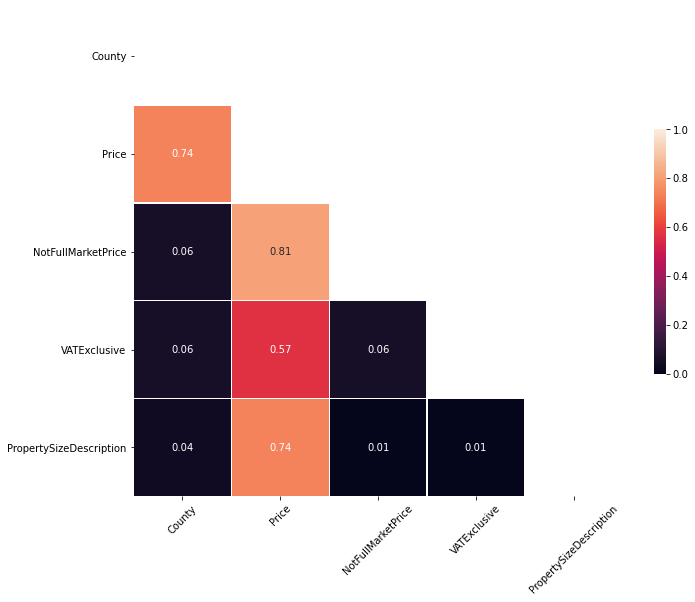

In [62]:
import matplotlib.pyplot as plt

mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, annot=True, mask=mask, vmax=1, vmin=0,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
# with sns.axes_style("white"):
#   ax = sns.heatmap(corr_df, mask=mask,vmin=0., vmax=1, square=True)

plt.yticks(rotation = 0)
plt.xticks(rotation = 45)
plt.show()

### Conclusion: From the correlation coefficient matrix, we see that the three characteristics that have the greatest relationship with Price are: "NotFullMarketPrice", "County", "PropertySizeDescription".
### It means that property price is more influenced by area (County) and house size, which is logical, the closer to the economic, political and cultural center, the higher the price must be; the larger the house size, the higher the price must be.

# 4.Create a few new features (at least 3) with the aim to better capture the problem domain and the target outcome.

In [63]:
new_df = PyMySQL.get_from_db(sql="SELECT * FROM ppr_with_google_address")
# new_df = pd.read_csv('ppr_with_google_address_20211342.csv')
new_df.shape

(10000, 10)

### Get the latitude and longitude, and the address type of the Address. The 3 most important things about Property Price: Location! Location! Location!

In [64]:
new_df['GoogleAddress'] = new_df['GoogleAddress'].apply(lambda x: json.loads(x))
new_df["lat"] = new_df["GoogleAddress"].apply(lambda a: a["results"][0]["geometry"]["location"]["lat"] if a["results"] else "")
new_df["lng"] = new_df["GoogleAddress"].apply(lambda a: a["results"][0]["geometry"]["location"]["lng"] if a["results"] else "")

In [65]:
new_df["address_types"] = new_df["GoogleAddress"].apply(lambda a: "-".join(a["results"][0]["types"])  if a["results"] else "")

### Transform the formatted address, drop the stree number, keep the rest part

In [66]:
def process_formatted_address(formatted_address):
    """process the formatted_address"""
    if formatted_address:
        addr_parts = str(formatted_address).split(",")
        # process the first part
        first_part = addr_parts[0]
        # if it begins with digit, remove the digits
        if first_part[0].isdigit:
            first_part = "_".join(first_part.split(" ")[1: ])
        # put together, then remove all spaces
        return (first_part + "-" + "-".join(addr_parts[1: ])).replace(" ", "")
    else:
        return ""

# def process_formatted_address(formatted_address):
#     """process the formatted_address"""
#     if formatted_address:
#         addr_parts = str(formatted_address).split(",")
#         return "-".join(addr_parts[1: ]).replace(" ", "")
#     else:
#         return ""

# def process_formatted_address(formatted_address):
#     """process the formatted_address"""
#     if formatted_address:
#         addr_parts = str(formatted_address).split(",")
#         return addr_parts[1]
#     else:
#         return ""

print(process_formatted_address("86 Mullaghmatt, Monaghan, Ireland"))
# new_df["formatted_address"]

Mullaghmatt-Monaghan-Ireland


In [67]:
new_df["formatted_address"] = new_df["GoogleAddress"].apply(lambda a: a["results"][0]["formatted_address"] if a["results"] else "")
new_df["transformed_address"] = new_df["formatted_address"].apply(lambda a: process_formatted_address(a))

### Transform the year and month, prices are affected by the economic cycle.

In [68]:
# Convert out
new_df['DateofSale'] = new_df['DateofSale'].astype('datetime64[ns]')
new_df["YearMonth"] = new_df["DateofSale"].apply(lambda d: d.year * 100 + d.month)

In [69]:
import scipy.stats as ss
import seaborn as sns
from sklearn import preprocessing

label = preprocessing.LabelEncoder()

for i in ["County", "NotFullMarketPrice", 
                     "VATExclusive", "DescriptionofProperty", "transformed_address",
                     "address_types"] :
    new_df[i] = label.fit_transform(new_df[i])

In [70]:
new_df['lat'] = new_df['lat'].apply(lambda x: float(x) if x else None)
new_df['lng'] = new_df['lng'].apply(lambda x: float(x) if x else None)

In [71]:
new_df["lat"].fillna(new_df["lat"].mean(), inplace=True)
new_df["lng"].fillna(new_df["lng"].mean(), inplace=True)

In [72]:
features_df = new_df[["YearMonth", "County", "NotFullMarketPrice", "lat", "lng",
                     "VATExclusive", "DescriptionofProperty", "transformed_address",
                     "address_types"]]
target_df = new_df["Price"]

### Choose the Top K features

In [73]:
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import pearsonr

# Choose the Top K features
# The first parameter is a function that calculates whether the evaluation feature is good or not.
# This function inputs a feature matrix and a target vector and outputs an array of binaries (scores, p-values).
bestfeatures = SelectKBest(score_func=f_regression, k=9)
fit = bestfeatures.fit(features_df, target_df)
pvalues_df = pd.DataFrame(fit.pvalues_)
scores_df = pd.DataFrame(fit.scores_)
columns_df = pd.DataFrame(features_df.columns)
#concat three dataframes for better visualization, the higher the score, the lower the p-value, the more important the feature is
feature_scores = pd.concat([columns_df, scores_df, pvalues_df], axis=1)
feature_scores.columns = ['Feature','Score', "P-Value"]  #naming the dataframe columns
feature_scores.sort_values(by="Score", ascending=False)

,Feature,Score,P-Value
1,County,40.874393,1.695825e-10
0,YearMonth,26.489892,2.699535e-07
8,address_types,4.305718,3.800998e-02
4,lng,1.643379,1.998922e-01
2,NotFullMarketPrice,1.395707,2.374717e-01
6,DescriptionofProperty,0.912071,3.395886e-01
5,VATExclusive,0.767069,3.811462e-01
3,lat,0.329678,5.658617e-01
7,transformed_address,0.058359,8.091143e-01


In [74]:
new_df.drop(columns=["GoogleAddress"], inplace=True)
new_df.to_csv("ppr_with_new_features_20211342.csv", index=False)